# Inf2 - Foundations of Data Science
## S2 Week 11: Estimation of confidence intervals with the bootstrap

**Learning outcomes:** In this lab you will use statistical simulations to undertake bootstrap estimation of confidence intervals. By the end of this lab you should be able to:
- code the bootstrap estimator for a number of estimators
- validate statistical coding by comparing the output of functions with known results
- interpret the output
- compare the output with confidence intervals obtained by other methods

This lab relates to the material in the topics on estimation and confidence intervals.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf # Regression library
from scipy.stats import norm # Object to with member functions to do with normal distributions
# Package to display the hints and soultions
from common.show_solutions import show

## A. Bootstrap - confidence intervals

Confidence intervals give us an indication of how sure we can be that an estimate lies within particular bounds. More precisely, we can state with a specified degree of certainty the chance that the true parameter lies in the confidence interval. For example, a 95% confidence interval has a chance of 0.95 of containing the true value. There is a trade-off between width and certainty: we can increase the width of the interval to be more certain (e.g. 99% certain).

We'll finish off what we started on the basketball data set in the previous lab. We had got to the point of generating the sample mean of samples of the age and salary. We'd now like to extend that code to generate confidence intervals for various statistics in the dataset. 

In [2]:
player_data = pd.read_csv("datasets/player_data.csv")
salary_data = pd.read_csv("datasets/salary_data.csv")
full_data = pd.merge(salary_data, player_data,
                     left_on="PlayerName", right_on="Name")
full_data['Salary']=full_data['Salary']/1000000
salary_data.head()

,PlayerName,Salary
0,Kobe Bryant,23500000
1,Amar'e Stoudemire,23410988
2,Joe Johnson,23180790
3,Carmelo Anthony,22458401
4,Dwight Howard,21436271


**Exercise 01:** Using the code from last week, and the information in the lecture notes, write a bootstrap estimation routine with $k=1000$ replications to:
1. plot the sampling distribution of the mean.
2. find a 95% confidence interval for the mean of the salary data.

In [3]:
# Run this cell to be offered with hints and solution
show(question=1)

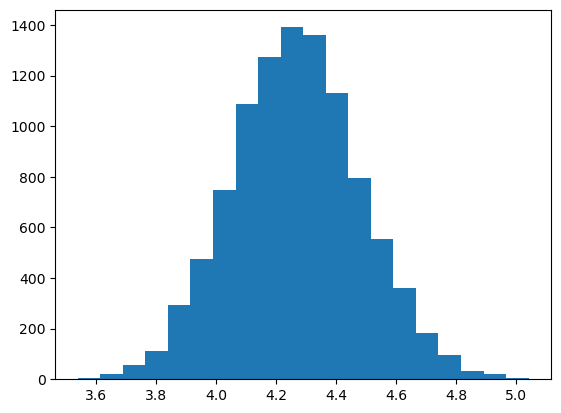

Confidence interval
0.0250    3.860196
0.0975    3.991588
dtype: float64


In [4]:
# Your code
salary = full_data['Salary']
k = 10000
n = len(salary_data)

x = np.zeros(k)
for i in range(k):
    x_sample = salary.sample(n,replace=True)
    x[i] = x_sample.mean()

plt.hist(x,20)
plt.show()
print("Confidence interval")
print(pd.Series(x).quantile([0.025,0.0975]))

### Engineering a bootstrap function

Later on in the lab, we are going to apply the bootstrap to a different estimator, and also run it repeatedly. We'd therefore like to turn it into a function.

**Exercise 02:** Write a function called bootstrap(), which takes as its input arguments:
1. `x`: pd.Series()
3. `estimator`: The function (e.g. `np.mean`) that you would like to get the bootstrap confidence intervals for. Note that you can pass functions as arguments to python functions.
4. `quantiles`: An array containing the desired quantiles
5. `plot`: Boolean indicating if a plot of the bootstrap distribution of the estimator should be shown. `False` by default.
 
It should return:
1. the quantiles
2. the bootstrap standard deviation

In [5]:
# Run this cell to be offered with hints and solution
show(question=2)

In [6]:
# Your code
def bootstrap(x, k=1000, estimator=np.mean, quantiles=[0.025,0.975], plot=False):
    n = len(x)
    x_list = np.zeros(k)
    for i in range(k):
        x_sample = np.random.choice(x, n , replace=True)
        x_list[i] = estimator(x_sample)

    if (plot):
        plt.hist(x_list, 20)
        plt.show()
    return(np.quantile(x_list, quantiles), np.std(x_list))

        
    
    
    

### Testing the function

When you want to deploy code you should always check that each function actually does what it is supposed to do. A good habit is to do what is called *unit testing* -  a method by which units of the code are checked for correctness. These are typically short code snippets that check automatically that the output of a function is as intended. In our setting, however, this would be overkill, and we can just check manually whether our function has the correct output on a known setting. In this, artificial, case we know the distribution, so we can estimate the SEM as $\sigma_{\overline{X}} = \sigma/\sqrt{n}$ . 

**Exercise 03:** 
- Compare the SEM computed from the full distribution with the bootstrap estimates.
- Are they of a similar size? If so, good - if not, go back and check the bootstrap function.
- Compare the quantiles produced by the function with the distribution produced with `plot=True`. Do the quantiles lie in the distribution?

In [7]:
# Run this cell to be offered with hints and solution
show(question=3)

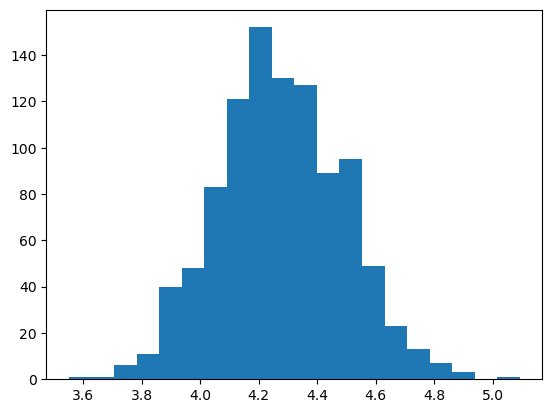

0.21520274889613247 0.21358469587024848 [3.87925854 4.70234705]


In [8]:
# Your code
SEM = np.std(salary, ddof=1)/np.sqrt(len(salary))
ci, std = bootstrap(salary, plot=True)
print(SEM, std, ci)

Your answer:

### Apply the bootstrap function to the median

The bootstrap is very flexible - here we use it to find confidence intervals for the median, rather than the mean.

**Exercise 04:** Apply your new bootstrap function to the confidence intervals of the median of the salaries, plotting the distribution.

In [9]:
# Run this cell to be offered with hints and solution
show(question=4)

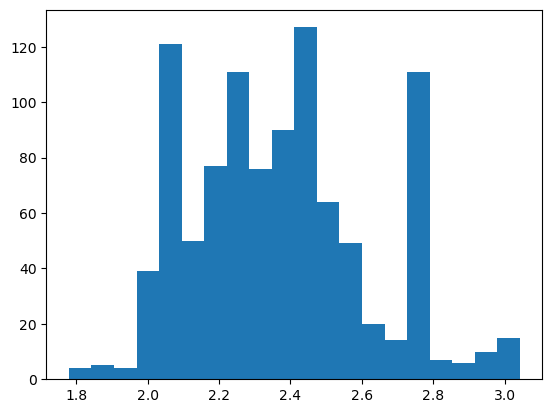

(array([2.        , 2.89535597]), 0.2451591668082899)

In [10]:
# Your code
bootstrap(salary, 1000, estimator=np.median, plot=True)

**Discussion:** Does the distribution of the sample median look as you would expect it to? If not, what is unusual about it? Can you explain why you're seeing this?

Your answer:

### Comparing the bootstrap and theoretical confidence intervals for the mean

**Exercise 05:** Determine the confidence interval for *the mean* using the theoretical method (not the bootstrap), assuming a normal distribution of the mean. Compare it with the results you got in **Exercises 02 and 03**.

In [11]:
# Run this cell to be offered with hints and solution
show(question=5)

In [12]:
# Your code
SEM = salary.std(ddof=1)/np.sqrt(len(salary))
xbar = salary.mean()

z = norm.isf(0.025)
ci = [xbar - z*SEM, xbar + z*SEM]
ci


[3.8479861290497253, 4.691565403470599]

Comment on your answer:

## B. Bootstrap applied to linear regression -  output from other packages

As we've said in the lectures, we can apply the bootstrap estimator to many different types of statistic, where by "statistic" we mean a value derived from the data. Above, for example, we have already used the median instead of the mean. Linear regression coefficients also count as statistics - so we should be able to used the bootstrap on them.
 
 **Exercise 06:** 
 - Create a new column of `full_data` called `LogSalary`, which is the log to the base 10 of `Salary`.
 - Plot the `LogSalary` against the `Age`.
 - Fit a linear regression of the `LogSalary` to the `Age` using `statsmodels`. (See the linear regression lab).
 - Extract the best fitting `Intercept` parameter and slope parameter (called `Age`) from the result. Hint: use the `params` member variable.

In [13]:
# Run this cell to be offered with hints and solution
show(question=6)

Intercept   -0.797333
Age          0.042749
dtype: float64

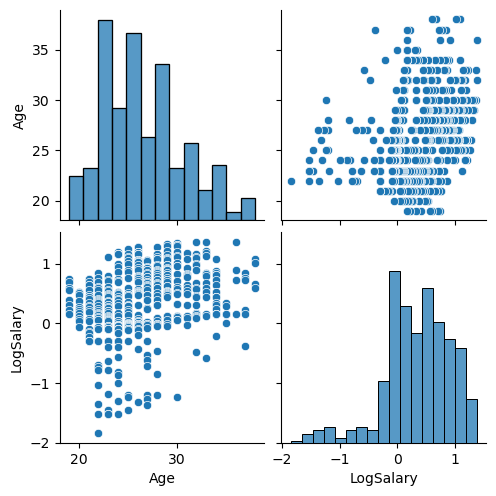

In [16]:
# Your code
full_data['LogSalary'] = np.log10(full_data['Salary'])
sns.pairplot(full_data, vars=['Age','LogSalary'])
model = smf.ols('LogSalary ~ Age' , data=full_data)
results = model.fit()
results.params

**Exercise 07:** Now use the code from exercise 06 to:

- Write a function `beta0hat` that, given a data frame `df` with the same format as `full_data` returns the fitted intercept. 
- Write a function `beta1hat` that returns the fitted slope (`Age`) parameter. 
- Test that it gets the correct results, when given `full_data` as an argument. 

In [17]:
# Run this cell to be offered with hints and solution
show(question=7)

In [20]:
# Your code
def beta0hat(df):
    model = smf.ols('LogSalary ~ Age' , data=df)
    results = model.fit()
    return results.params['Intercept']

def beta1hat(df):
    model = smf.ols('LogSalary ~ Age' , data=df)
    results = model.fit()
    return results.params['Age']
print(beta0hat(full_data))
print(beta1hat(full_data))

-0.7973333757451674
0.04274912662568664


**Exercise 08:** 
- Write a function `bootstrap_df`, which is the same as `bootstrap`, but in which the estimator can take a DataFrame as an argument, and return a statistic (i.e., just like the function `beta0hat` does).
- Write a function `salary_mean` that returns the mean of the `Salary` column of a data frame, and use it to verify that `bootstrap_df` gives similar results to the ones you obtained above.

In [21]:
# Run this cell to be offered with hints and solution
show(question=8)

In [29]:
# Your code
def bootstrap_df(df, k = 1000 , estimator = beta0hat, quantiles = [0.025,0.975], plot = False):
    n = len(df)
    x_list = np.zeros(k)
    for i in range(k):
        x_sample = df.sample(n,replace=True)
        x_list[i] = estimator(x_sample)
    if (plot):
        plt.hist(x_list, 20)
    return(np.quantile(x_list, quantiles), np.std(x_list))

def salary_mean(df):
    return df['Salary'].mean()

bootstrap_df(full_data, estimator=salary_mean)

(array([3.87355868, 4.67869643]), 0.20683383089984567)

**Exercise 09:**
Now apply the `bootstrap_df` function to get confidence intervals of
1. the `Intercept` coefficient $\hat\beta_0$ of the linear regression of `Age` on `LogSalary`
2. the slope coefficient $\hat\beta_1$ of the linear regression of `Age` on `LogSalary`.

In [34]:
# Run this cell to be offered with hints and solution
show(question=9)

In [35]:
# Your code
beta0_est = bootstrap_df(full_data, estimator=beta0hat)
beta1_est = bootstrap_df(full_data, estimator=beta1hat)
print(beta0_est)
print(beta1_est)

(array([-1.08678207, -0.5420301 ]), 0.14192013446412383)
(array([0.03289021, 0.05330212]), 0.005410371560849095)


## C. Comparison of bootstrap and theoretical confidence interval

In this example, we don't actually have to use the bootstrap to estimate the confidence intervals; statsmodels (and many other packages) can estimate the standard error of the sampling distribution of the estimator. Run the statsmodels fit again, but this time report all the output using the `summary`.

In [37]:
model = smf.ols('LogSalary ~ Age', data=full_data)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              LogSalary   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     51.14
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           3.15e-12
Time:                        16:37:50   Log-Likelihood:                -407.87
No. Observations:                 492   AIC:                             819.7
Df Residuals:                     490   BIC:                             828.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7973      0.161     -4.965      0.000      -1.113      -0.482
Age            0.0427      0.006      7.151      0.000       0.031       0.054
==============================================================================
Omnibus:                       58.598   Durbin-Watson:                   0.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.073
Skew:                          -0.838   Prob(JB):                     1.51e-18
Kurtosis:                       4.094   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Look at the middle table of the results, containing the `Intercept` and `Age` variables. In the topic and lab on linear regression we learned how to interpret the `coeff` column. We should now be able to understand the `std err` and `[0.025` and `0.975]` columns. 
- `coeff`: best estimate of `Intercept` and `Age`
- `std err`: the standard error of the estimators of `Intercept` and `Age`
- `[0.025`: lower bound of the 95% confidence interval of the estimators of `Intercept` and `Age`
- `0.025]`: upper bound of the 95% confidence interval of the estimators of `Intercept` and `Age`

**Discussion**:
- Are the standard errors reported here close to the bootstrap estimates? 
- Are the confidence intervals close to the bootstrap estimates?

In [38]:
# Run this cell to be offered with hints and solution
show(question=10)

Your answer:


You should find that the confidence intervals are close to the bootstrap estimates. If not, check your bootstrap code again!

### The meaning of the `t` and `P>|t|` columns

The `t` column contains the $t$ statistics for the estimator of the intercept $\hat\beta_0$ and estimator of the gradient $\hat\beta_1$. For any estimator $\hat\theta$ the $t$ statistic is defined: 

$$t = \frac{\hat\theta - 0}{\hat\sigma_{\hat\theta}}$$

Here $\hat\theta$ is the estimator for the parameter and $\hat\sigma_{\hat\sigma}$ is the estimated standard error of the estimator.  We replace $\hat\theta$ with $\hat\beta_0$ to get the $t$-statistic of the intercept and we replace $\hat\theta$ with $\hat\beta_1$ to get the $t$-statistic of the gradient.  You can check that for each of the intercept and the gradient `t` does indeed equal the coefficient divided by the corresponding standard error. 

The $t$ statistic measures how far the estimated parameter (i.e. the coefficient found by statsmodels) is from zero, in units of the standard error of the estimator. Intuitively, the larger $t$ is, the less likely it is that the true value of the coefficient could be zero. 

The `P>|t|` column has to do with a hypothesis test. The null and alternative hypotheses are:

- H<sub>0</sub> The true value of the parameter is equal to zero

- H<sub>a</sub>: The parameter is equal to something else

Due to the duality between confidence intervals and hypothesis tests, to test the null hypothesis we can consider the area in the tail of the sampling distribution of the estimator beyond 0 to be the *p*-value. The larger $t$ is, the smaller the area in the tail will be. In the case of both the Age and the log Salary, this *p*-value `P>|t|` is 0.  

**Discussion:** Is the null hypothesis rejected or not? Does this make sense when you compare the confidence intervals to 0?

In [39]:
# Run this cell to be offered with hints and solution
show(question=11)

Your answer

